In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
os.chdir(processed)
df = pd.read_csv('data.csv')

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20546 entries, 0 to 20545
Data columns (total 92 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_education                                    20546 non-null  float64
 1   consumption_personal                                     20546 non-null  float64
 2   income_transfers                                         20546 non-null  float64
 3   income_other                                             20546 non-null  float64
 4   consumption_clothing                                     20546 non-null  float64
 5   location_size                                            20546 non-null  int64  
 6   consumption_food                                         20546 non-null  float64
 7   consumption_current                                      20546 non-null  float64
 8   financial_income          

In [123]:
df['post'] = df['Y'] == 1996
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [124]:
df = (df.query('income > 0')
      .query('consumption > 0'))

In [125]:

import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20448


/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7fcb3c29dc10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7fcb3c29dc10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)


In [126]:

dummies ={}
dummies_names = []

df['age_sq'] = df['age'] ** 2
to_dummies = ['sex', 'education', 'location_size', 'decile']

for var in to_dummies:
    print('Making dummies for', var)
    dummies[var] = pd.get_dummies(df[var], drop_first=True, prefix=var)
    dummies_names += list(dummies[var].columns)


Making dummies for sex
Making dummies for education
Making dummies for location_size
Making dummies for decile


In [127]:
for data in dummies.values():
    df = pd.concat([df, data], axis=1)

In [128]:
df['post_decile'] = df['post'] * df['decile']
C_post_decile = pd.get_dummies(df['post_decile'], prefix='post_decile')
C_post_decile = C_post_decile.drop(columns=['post_decile_0'])
dummies_names += list(C_post_decile.columns)
df = pd.concat([df, C_post_decile], axis=1)

In [129]:
C_post_decile

post_decile_1  post_decile_2  post_decile_3  post_decile_4  \
0              False          False          False          False   
1              False          False          False          False   
2              False          False          False          False   
3              False          False          False          False   
4              False          False          False          False   
...              ...            ...            ...            ...   
20443          False          False          False          False   
20444          False          False           True          False   
20445           True          False          False          False   
20446          False          False          False          False   
20447          False           True          False          False   

       post_decile_5  post_decile_6  post_decile_7  post_decile_8  \
0              False          False          False          False   
1              False          False          False          False   
2              False          False          False          False   
3              False          False          False          False   
4              False          False          False          False   
...              ...            ...            ...            ...   
20443           True          False          False          False   
20444          False          False          False          False   
20445          False          False          False          False   
20446          False          False           True          False   
20447          False          False          False          False   

       post_decile_9  post_decile_10  
0              False           False  
1              False           False  
2              False           False  
3              False           False  
4              False           False  
...              ...             ...  
20443          False           False  
20444          False           False  
20445          False           False  
20446          False           False  
20447          False           False  

[20448 rows x 10 columns]

In [130]:
df[dummies_names]

sex_Male  education_Low  education_Medium  location_size_2  \
0          True           True             False            False   
1          True           True             False            False   
2          True           True             False            False   
3          True           True             False            False   
4          True          False             False            False   
...         ...            ...               ...              ...   
20443      True           True             False            False   
20444      True          False              True            False   
20445      True           True             False            False   
20446     False           True             False             True   
20447      True          False             False            False   

       location_size_3  location_size_4  decile_2  decile_3  decile_4  \
0                False            False     False     False     False   
1                False            False     False     False     False   
2                False            False     False     False     False   
3                False            False     False     False     False   
4                False            False     False     False     False   
...                ...              ...       ...       ...       ...   
20443            False            False     False     False     False   
20444            False            False     False      True     False   
20445            False            False     False     False     False   
20446            False            False     False     False     False   
20447            False            False      True     False     False   

       decile_5  ...  post_decile_1  post_decile_2  post_decile_3  \
0          True  ...          False          False          False   
1         False  ...          False          False          False   
2         False  ...          False          False          False   
3         False  ...          False          False          False   
4         False  ...          False          False          False   
...         ...  ...            ...            ...            ...   
20443      True  ...          False          False          False   
20444     False  ...          False          False           True   
20445     False  ...           True          False          False   
20446     False  ...          False          False          False   
20447     False  ...          False           True          False   

       post_decile_4  post_decile_5  post_decile_6  post_decile_7  \
0              False          False          False          False   
1              False          False          False          False   
2              False          False          False          False   
3              False          False          False          False   
4              False          False          False          False   
...              ...            ...            ...            ...   
20443          False           True          False          False   
20444          False          False          False          False   
20445          False          False          False          False   
20446          False          False          False           True   
20447          False          False          False          False   

       post_decile_8  post_decile_9  post_decile_10  
0              False          False           False  
1              False          False           False  
2              False          False           False  
3              False          False           False  
4              False          False           False  
...              ...            ...             ...  
20443          False          False           False  
20444          False          False           False  
20445          False          False           False  
20446          False          False           False  
20447          False          False           Fal

In [132]:
continuous = ['age', 'age_sq']
X_col = continuous + dummies_names
X = df[X_col]
Y = df[['log_income']]

In [133]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X, Y, sample_weight=df['weight'])
linear.coef_

array([[-3.78278425e-03,  5.41841696e-05, -9.22691120e-03,
        -8.74204237e-02, -8.59057035e-02, -1.01840367e-02,
        -1.59272329e-02, -4.64873339e-02,  7.65987991e-01,
         1.10461744e+00,  1.37010270e+00,  1.60504080e+00,
         1.84115519e+00,  2.09958335e+00,  2.40236577e+00,
         2.82415447e+00,  3.66124891e+00, -1.98656375e-01,
        -2.27760584e-01, -2.35976011e-01, -2.33607507e-01,
        -2.43453826e-01, -2.52810678e-01, -2.70550731e-01,
        -2.95678876e-01, -3.24713585e-01, -3.43764503e-01]])

In [136]:
linear.coef_.T[-10:]

array([[-0.19865637],
       [-0.22776058],
       [-0.23597601],
       [-0.23360751],
       [-0.24345383],
       [-0.25281068],
       [-0.27055073],
       [-0.29567888],
       [-0.32471358],
       [-0.3437645 ]])

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
linear = sm.families.Gaussian(identity())

In [36]:
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
consumption_reg = 'log_consumption ~ ' + Z + '+' + D

In [37]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [38]:
nboot = 500
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    data_boot = df.sample(len(data), weights=df['weight'], replace=True, axis=0)
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=linear).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=linear).fit()
    dincome[boot, :] = income_model.params[params]


In [39]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]

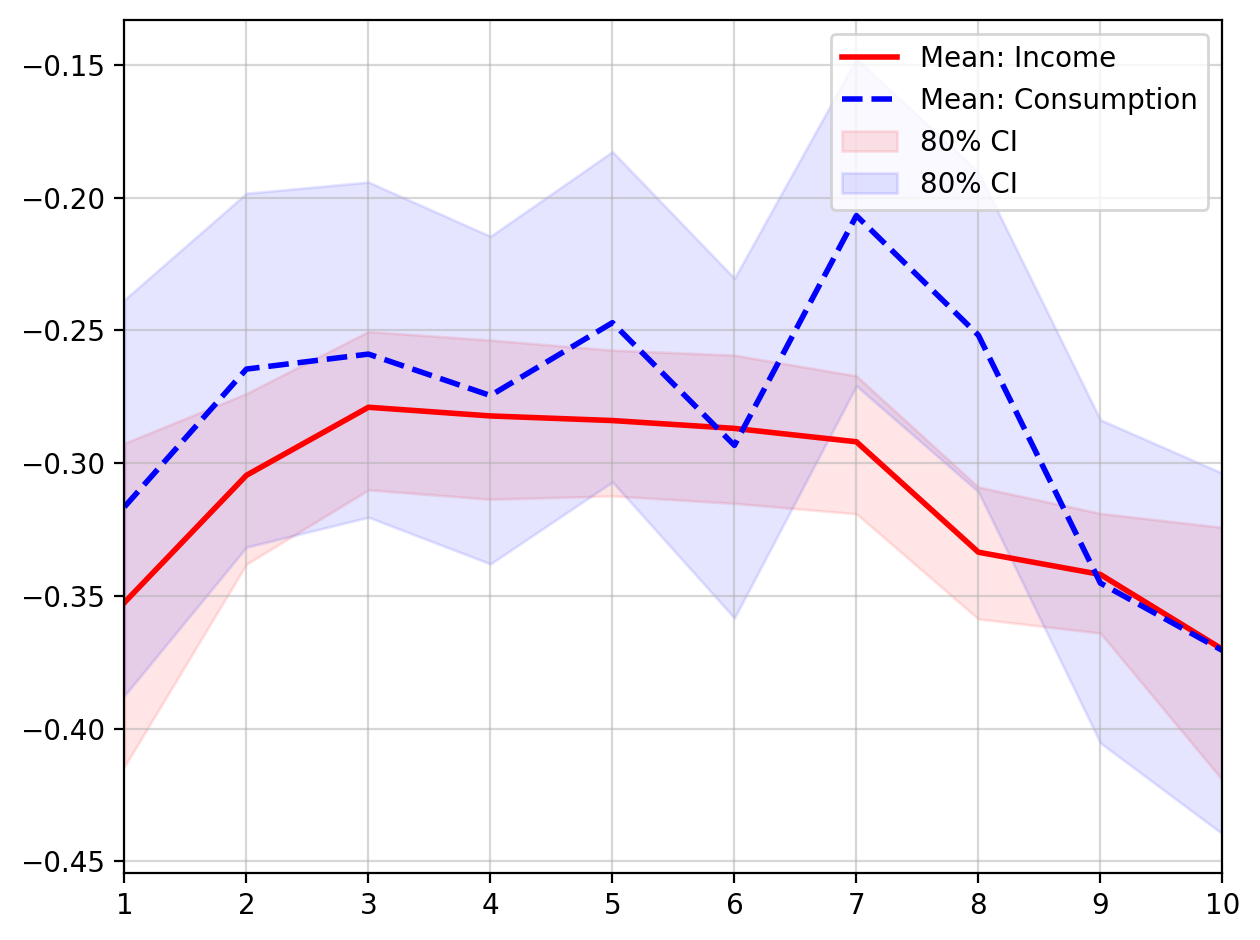

In [40]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

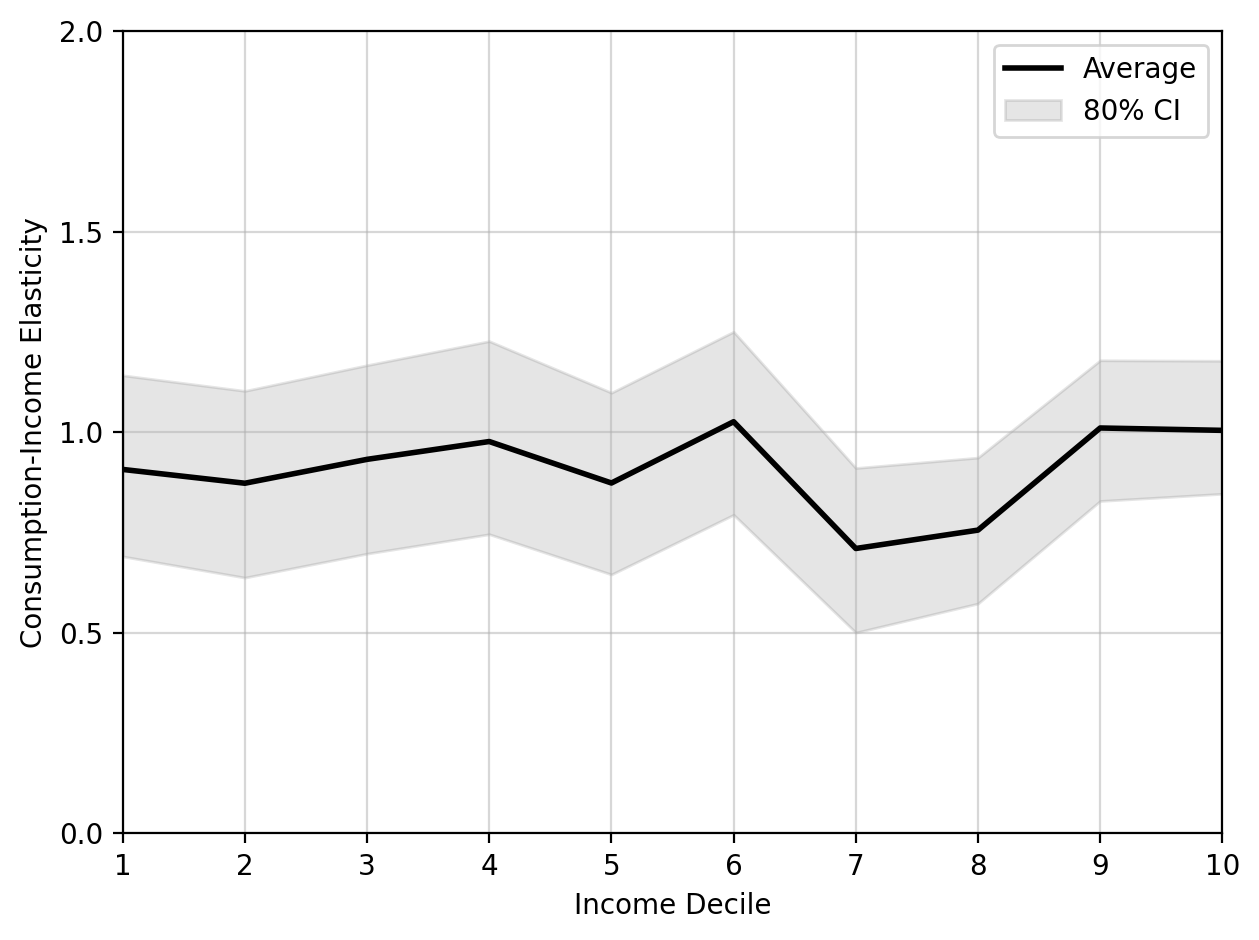

In [42]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure()

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

#if save:
    #os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)